In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal

In [2]:
df = pd.read_csv("../data/creditcard.csv")

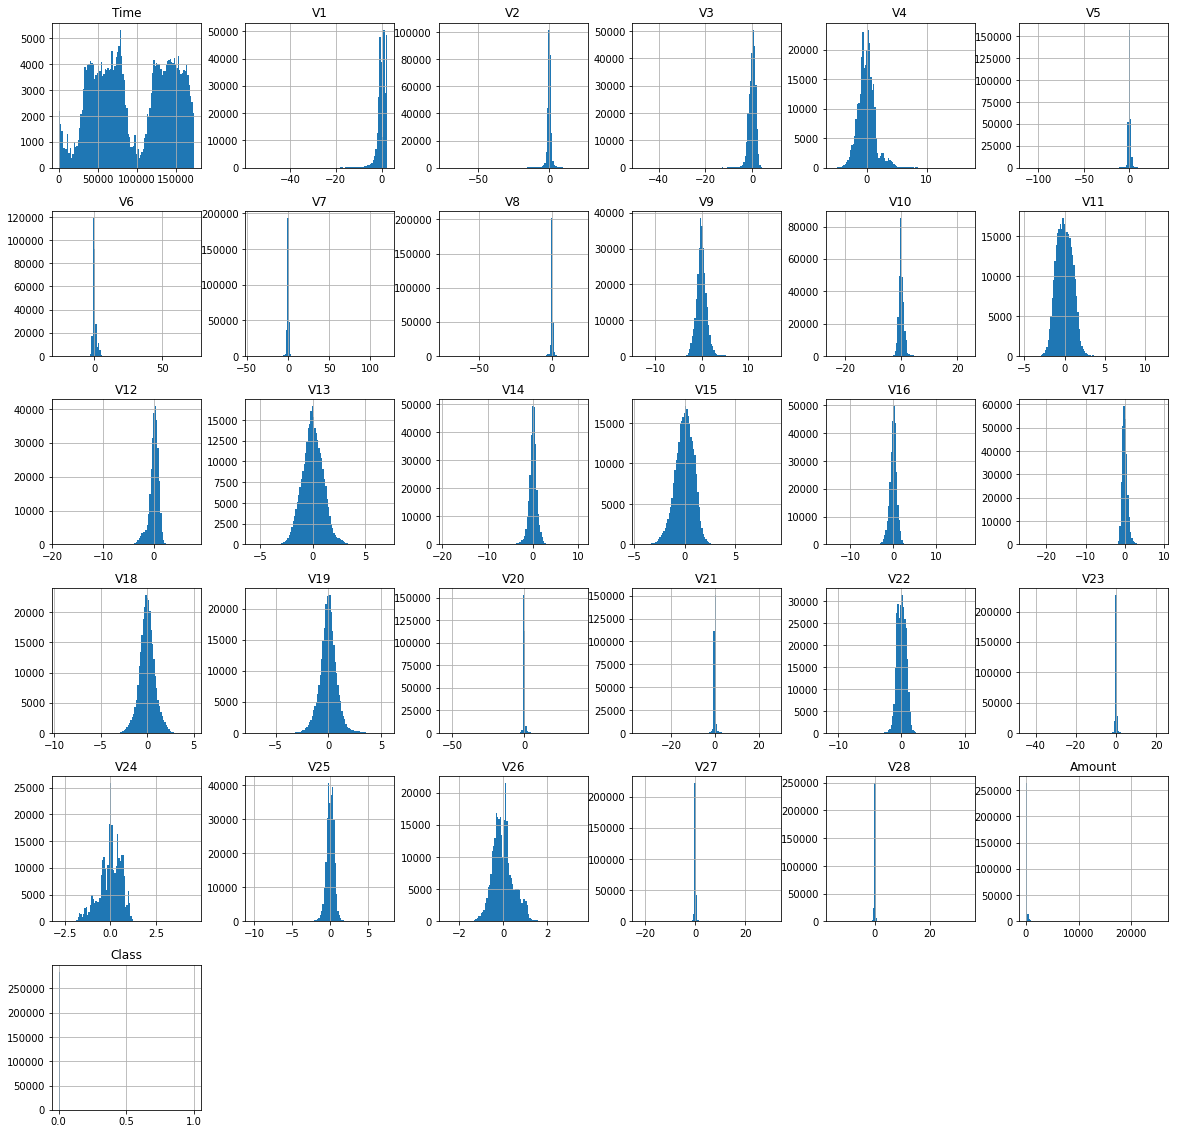

In [3]:
hist = df.hist(bins=100, figsize = (20,20))

From the graphs above we will chose the parameter that look the most like a gaussian distribution

In [4]:
features = ["V9","V11","V13","V15","V18","V19","V14","Class"]

We find the meand and covariance matrix of each feature our dataset and apply them to create a multivariate gaussian distribution

In [5]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
   
    return mu, sigma

def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

For our algorithm to work we will need to find the distribution of our dataset and compare the outlier to a p-value or epsilon

Because our data is a little bit unusal having only 492 anomaly we can improve our score by spltting the dataset manually note that this has nothing to do with the detection it's just for splitting purposes 


In [6]:

def train_test_cross_split(train_df):   
    train_strip_v1 = train_df[train_df["Class"] == 1]
    train_strip_v0 = train_df[train_df["Class"] == 0]

    Normal_len = len (train_strip_v0)
    Anomolous_len = len (train_strip_v1)

    start_mid = Anomolous_len // 2
    start_midway = start_mid + 1

    train_cv_v1  = train_strip_v1 [: start_mid]
    train_test_v1 = train_strip_v1 [start_midway:Anomolous_len]

    start_mid = (Normal_len * 60) // 100
    start_midway = start_mid + 1

    cv_mid = (Normal_len * 80) // 100
    cv_midway = cv_mid + 1

    # Assuming the fact that we have 1% of anomalie there is a small chance that our train will contain some
    train_fraud = train_strip_v0 [:start_mid] 
    train_cv    = train_strip_v0 [start_midway:cv_mid]
    train_test  = train_strip_v0 [cv_midway:Normal_len]

    train_cv = pd.concat([train_cv,train_cv_v1],axis=0)
    train_test = pd.concat([train_test,train_test_v1],axis=0)

    train_cv_y = train_cv["Class"]
    train_test_y = train_test["Class"]

    train_cv.drop(labels = ["Class"], axis = 1, inplace = True)
    train_fraud.drop(labels = ["Class"], axis = 1, inplace = True)
    
    
    return train_fraud, train_cv, train_test, train_cv_y, train_test_y


Now that we have crooss_validation train and test dataset let's find the anomalies using the gaussian distribution


In [7]:
def creating_distribution(train_fraud,train_cv,train_test):    
    mu, sigma = estimateGaussian(train_fraud)
    p = multivariateGaussian(train_fraud,mu,sigma)
    p_cv = multivariateGaussian(train_cv,mu,sigma)
    test = train_test.drop(labels = ["Class"], axis = 1)
    p_test = multivariateGaussian(test,mu,sigma)
    return p, p_cv, p_test

select the best threshold to find the outlier based on the notion of p value, value lower then this epsilon value is concidered as outlier using the cv validation set


In [8]:
def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    farray = []
    Recallarray = []
    Precisionarray = []
    epsilons = (0.0000e+00, 1.0527717316e-70, 1.0527717316e-50, 1.0527717316e-24)
    #epsilons = np.asarray(epsilons)
    for epsilon in epsilons:
        predictions = (probs < epsilon)
        f = f1_score(gt, predictions, average = "binary")
        Recall = recall_score(gt, predictions, average = "binary")
        Precision = precision_score(gt, predictions, average = "binary")
        farray.append(f)
        Recallarray.append(Recall)
        Precisionarray.append(Precision)
        print ('For below Epsilon')
        print(epsilon)
        print ('F1 score , Recall and Precision are as below')
        print ('Best F1 Score %f' %f)
        print ('Best Recall Score %f' %Recall)
        print ('Best Precision Score %f' %Precision)
        print ('-'*40)
        if f > best_f1:
            best_f1 = f
            best_recall = Recall
            best_precision = Precision
            best_epsilon = epsilon    
    
    return best_f1, best_epsilon

We can test this on our test data

In [9]:
def evaluation(p_test,ep,train_test_y):

        pred = (p_test < ep)

        f = f1_score(train_test_y, pred, average = "binary")
        Recall = recall_score(train_test_y, pred, average = "binary")
        Precision = precision_score(train_test_y, pred, average = "binary")

        print(r'F1 Score (test) = {}'.format(f))
        print(r'Recall Score (test) = {}'.format(Recall))
        print(r'Precision Score (test) = {}'.format(Precision))
        return pred

In [13]:
def graphs(predictions,p_test,train_test_y,train_test,col1,col2):
    print(" ")
    print(r'--------------------- {}, {} ---------------------'.format(col1,col2))
    False_positive = 0
    False_negative = 0
    True_negative = 0
    True_positive = 0
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(train_test[col1],train_test[col2],marker="o", color="lightBlue")
    ax.set_title('Anomalies(in red) vs Predicted Anomalies(in Green)')
    for i, txt in enumerate(train_test[col1].index):
           if (predictions[i] == False) and (train_test_y.loc[txt] == 0):
                True_negative+=1
                
           if predictions[i] == True and (train_test_y.loc[txt] == 1):
                ax.annotate('o', (train_test[col1].loc[txt],train_test[col2].loc[txt]),fontsize=15,color='Green')
                True_positive+=1
           if (predictions[i] == False) and (train_test_y.loc[txt] == 1):
                ax.annotate('x', (train_test[col1].loc[txt],train_test[col2].loc[txt]),fontsize=15,color='Black')
                False_negative+=1
           if (predictions[i] == True) and (train_test_y.loc[txt] == 0):
                ax.annotate('o', (train_test[col1].loc[txt],train_test[col2].loc[txt]),fontsize=15,color='Purple')
                False_positive+=1
    plt.show()
    print("True Positive = ",True_positive)
    print("True Negative = ",True_negative)
    print("False Positive = ",False_positive)
    print("False Negative = ",False_negative)
    print(" ")
    print("---- Confusion Matrix ----")
    print(True_positive,"  |  ", False_positive)
    print(False_negative,"  |  ", True_negative)
    print(" ")

In [14]:
def pipeline(train_df):
    (train_fraud,
    train_cv,
    train_test,
    train_cv_y,
    train_test_y) = train_test_cross_split(train_df)
    p,p_cv,p_test = creating_distribution(train_fraud,train_cv,train_test)
    f_1,ep = selectThresholdByCV(p_cv,train_cv_y)
    pred = evaluation(p_test, ep, train_test_y)
    graphs(pred, p_test, train_test_y,train_test,"V19","V11")
    graphs(pred, p_test, train_test_y,train_test,"V9","V14")
    graphs(pred, p_test, train_test_y,train_test,"V15","V18")
    pred = evaluation(p_test, ep, train_test_y)
    return train_test,ep,train_test_y
    

/tmp/ipykernel_13995/2373002761.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fraud.drop(labels = ["Class"], axis = 1, inplace = True)
/home/patrick/miniconda3/envs/ts/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For below Epsilon
0.0
F1 score , Recall and Precision are as below
Best F1 Score 0.000000
Best Recall Score 0.000000
Best Precision Score 0.000000
----------------------------------------
For below Epsilon
1.0527717316e-70
F1 score , Recall and Precision are as below
Best F1 Score 0.309278
Best Recall Score 0.182927
Best Precision Score 1.000000
----------------------------------------
For below Epsilon
1.0527717316e-50
F1 score , Recall and Precision are as below
Best F1 Score 0.397394
Best Recall Score 0.247967
Best Precision Score 1.000000
----------------------------------------
For below Epsilon
1.0527717316e-24
F1 score , Recall and Precision are as below
Best F1 Score 0.663484
Best Recall Score 0.565041
Best Precision Score 0.803468
----------------------------------------
F1 Score (test) = 0.6321243523316062
Recall Score (test) = 0.49795918367346936
Precision Score (test) = 0.8652482269503546
 
--------------------- V19, V11 ---------------------


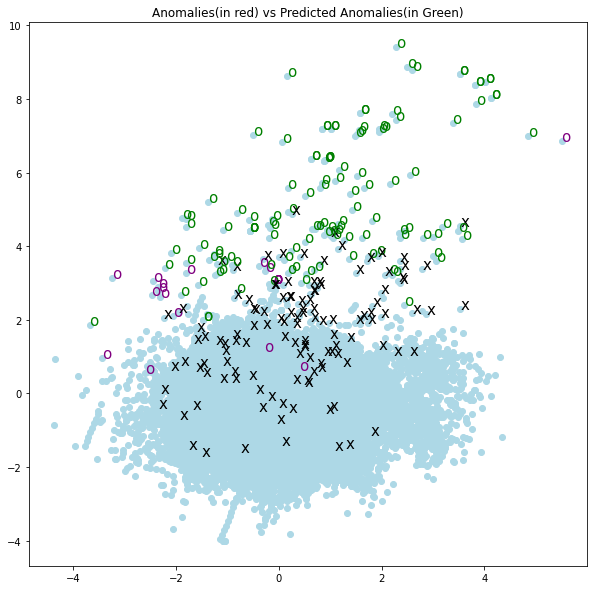

True Positive =  122
True Negative =  56843
False Positive =  19
False Negative =  123
 
---- Confusion Matrix ----
122   |   19
123   |   56843
 
 
--------------------- V9, V14 ---------------------


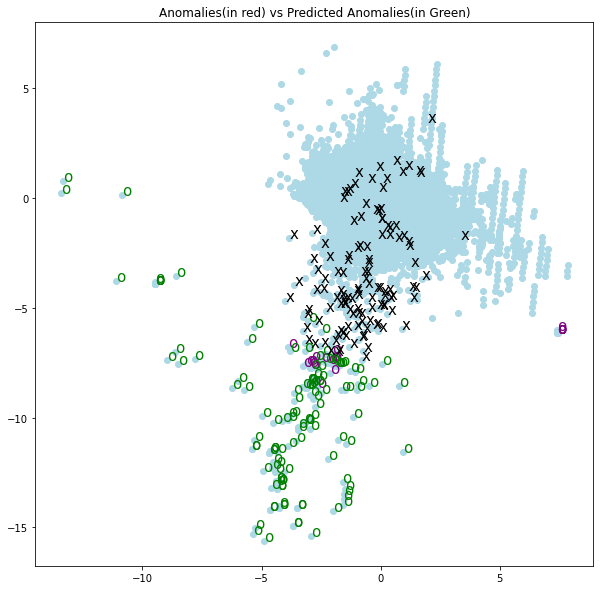

True Positive =  122
True Negative =  56843
False Positive =  19
False Negative =  123
 
---- Confusion Matrix ----
122   |   19
123   |   56843
 
 
--------------------- V15, V18 ---------------------


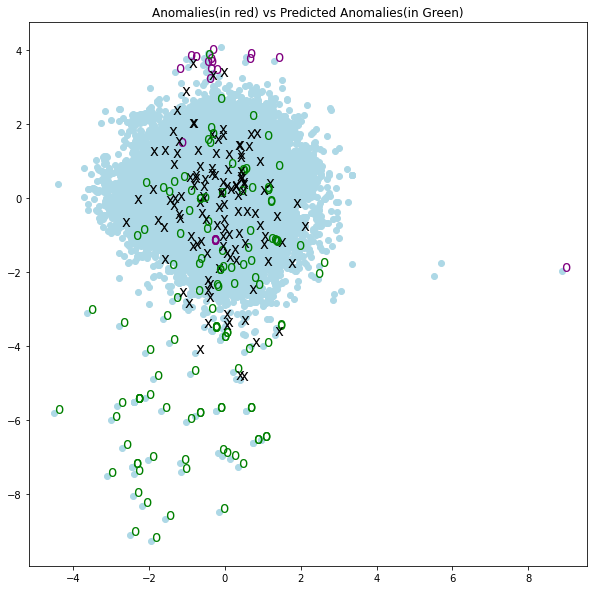

True Positive =  122
True Negative =  56843
False Positive =  19
False Negative =  123
 
---- Confusion Matrix ----
122   |   19
123   |   56843
 
F1 Score (test) = 0.6321243523316062
Recall Score (test) = 0.49795918367346936
Precision Score (test) = 0.8652482269503546


In [15]:
train_df = df[features]
t,ep,train_test_y = pipeline(train_df)

### Our best score
* F1 = 0.66
* Recall = 0.56
* Precision = 0.8
* eps = 1.0527717316e-24

### Results analysis

The reason behind this innacurate result is that first, our balanced is really umbalanced the amount of anomalies is less than 1% which can impact the result a lot

The second reason is that our distribution is based on the data as a whole and the unusual data point found in our dataset, but maybe one of the value is an anomalie based on the previous one(s) 

But this doesn't remove the fact that the gaussian anomalie detection is still a good method for our dataset for the same reason as small anomalie, because by definition is an unusual data point which can be well defined using a Gaussian distribution and ⁻value comapraison


### Graph analysis

* Black are the False Negative 
* Green are the True Positives
* Purple are the False Positive

Most outliers outside the cloud of point are detected but the algorithm is having difficulties detecting outliers inside the cloud, False negatives are mostly located inside the area of points

For different columns chosen the result different aspect of the outliers this can depend on the correlation between the amount of anomalies and the relation that can be found between the anomalies and different columns and to get a more accurate result we can use the multiple graph that we found to generate a more precise distribution between 3 or more feature that has the best representation of the anolies

For example between col 15 and 18 the anomalies are detected inside the graph 